# Investigating the effect of RESET

This notebook contains the implementation of investigating the effect of RESET reported in Section 4.2 of our paper.

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.utils.utils import load_model
from source.utils.connect import interpolate_state_dicts, reset_bn_stats
from source.utils.data_funcs import load_data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from source.utils.train import train, validate
import numpy as np
from copy import deepcopy
from source.utils.logger import Logger
from source.utils.weight_matching import weight_matching, get_permutation_spec
from source.utils.activation_matching import activation_matching
import matplotlib.pyplot as plt

In [3]:
Logger.setup_logging()
logger = Logger()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class config:
    model = 'cifar_vgg16_bn'
    dataset = 'cifar10'
    print_freq = 100
    path = '../data' # path to dataset
    special_init = 'vgg_init'
    

In [5]:
trainset, testset = load_data(config.path, config.dataset)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
seed = 30
sd_1 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_1_160.pt', map_location=device, weights_only=True)
sd_2 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_2_160.pt', map_location=device, weights_only=True)
model_1 = load_model(config, 3).to(device)
model_2 = load_model(config, 3).to(device)
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)
model_mid = deepcopy(model_1)
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
model_mid.load_state_dict(sd_mid)
with torch.autocast(device.type):
    validate(testloader, model_2, criterion, device, config)
# obtain the merged midpoint model
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
model_mid_wm = deepcopy(model_1)
sd_mid_wm = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)
model_mid_wm.load_state_dict(sd_mid_wm)
with torch.autocast(device.type):
    validate(testloader, model_mid_wm, criterion, device, config)
reset_bn_stats(model_mid_wm, device, trainloader)
sd_mid_wm_reset = deepcopy(model_mid_wm.state_dict())

[2024-12-14 11:37:58] (22192) {utils.py:69}INFO - Test: [ 1/79]	Time  1.501 ( 1.501)	Loss 2.7538e-01 (2.7538e-01)	Acc@1  93.75 ( 93.75)	Acc@5 100.00 (100.00)
[2024-12-14 11:37:59] (22192) {utils.py:74}INFO -  *   Acc@1 93.350 Acc@5 99.720


0/P_Conv_27:
oldL: 27.998321533203125
newL: 44.08915710449219
newL - oldL: 16.090835571289062
0/P_Conv_7:
oldL: 744.2042236328125
newL: 903.1402587890625
newL - oldL: 158.93603515625
0/P_Conv_10:
oldL: 328.58416748046875
newL: 414.33367919921875
newL - oldL: 85.74951171875
0/P_Conv_24:
oldL: 76.08331298828125
newL: 120.54251098632812
newL - oldL: 44.459197998046875
0/P_Conv_20:
oldL: 141.83074951171875
newL: 171.7251739501953
newL - oldL: 29.894424438476562
0/P_Conv_30:
oldL: 13.3580322265625
newL: 20.504627227783203
newL - oldL: 7.146595001220703
0/P_Conv_40:
oldL: 44.97272491455078
newL: 107.43290710449219
newL - oldL: 62.460182189941406
0/P_Conv_3:
oldL: 829.234619140625
newL: 1168.2188720703125
newL - oldL: 338.9842529296875
0/P_Conv_14:
oldL: 440.0552062988281
newL: 563.0275268554688
newL - oldL: 122.97232055664062
0/P_Conv_37:
oldL: 5.787487983703613
newL: 17.864299774169922
newL - oldL: 12.076811790466309
0/P_Conv_0:
oldL: 252.52005004882812
newL: 468.00115966796875
newL - oldL:

[2024-12-14 11:38:02] (22192) {utils.py:69}INFO - Test: [ 1/79]	Time  0.062 ( 0.062)	Loss 2.8359e+00 (2.8359e+00)	Acc@1  16.41 ( 16.41)	Acc@5  65.62 ( 65.62)


23/P_Conv_14:
oldL: 641.4592895507812
newL: 641.4592895507812
newL - oldL: 0.0
23/P_Conv_30:
oldL: 39.411460876464844
newL: 39.41176986694336
newL - oldL: 0.000308990478515625
24/P_Conv_27:
oldL: 80.28665161132812
newL: 80.28665161132812
newL - oldL: 0.0
24/P_Conv_24:
oldL: 167.24432373046875
newL: 167.24432373046875
newL - oldL: 0.0
24/P_Conv_20:
oldL: 230.78030395507812
newL: 230.78030395507812
newL - oldL: 0.0
24/P_Conv_34:
oldL: 37.261600494384766
newL: 37.261600494384766
newL - oldL: 0.0
24/P_Conv_30:
oldL: 39.41176986694336
newL: 39.41176986694336
newL - oldL: 0.0
24/P_Conv_14:
oldL: 641.4592895507812
newL: 641.4592895507812
newL - oldL: 0.0
24/P_Conv_0:
oldL: 516.0387573242188
newL: 516.0387573242188
newL - oldL: 0.0
24/P_Conv_10:
oldL: 519.4239501953125
newL: 519.4239501953125
newL - oldL: 0.0
24/P_Conv_7:
oldL: 1002.5337524414062
newL: 1002.5337524414062
newL - oldL: 0.0
24/P_Conv_40:
oldL: 119.31547546386719
newL: 119.31547546386719
newL - oldL: 0.0
24/P_Conv_17:
oldL: 405.90

[2024-12-14 11:38:04] (22192) {utils.py:74}INFO -  *   Acc@1 15.160 Acc@5 62.360


When applying RESET, the primary change involves modifying the `running_mean` and `running_var`. By comparing the running statistics before and after the RESET, we observe that the `running_mean` remains largely unchanged, while the `running_var` decreases significantly. Recalling the forward calculation for reference, a large estimated `running_var` tends to scale the output down, resulting in smaller values. This behavior mirrors what we observed in the linear networks, where the input-induced features progressively shrinks in scale as the network deepens. In this context, the RESET essentially acts as a form of bias correction—not by reducing the scale of the model biases, but rather by increasing the scale of input-induced features.

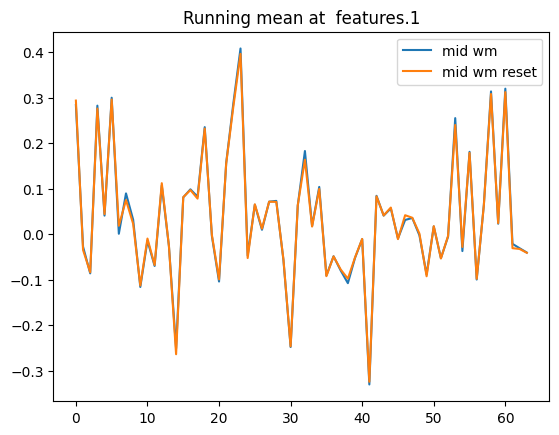

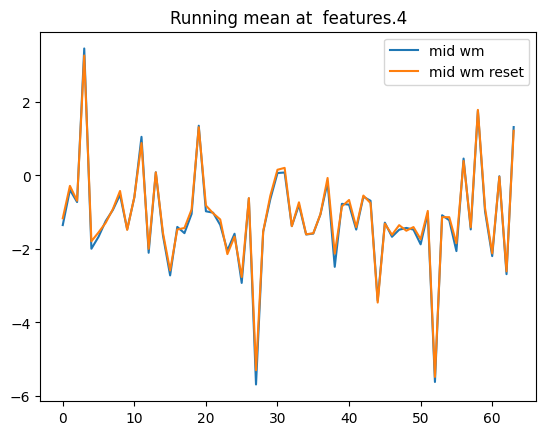

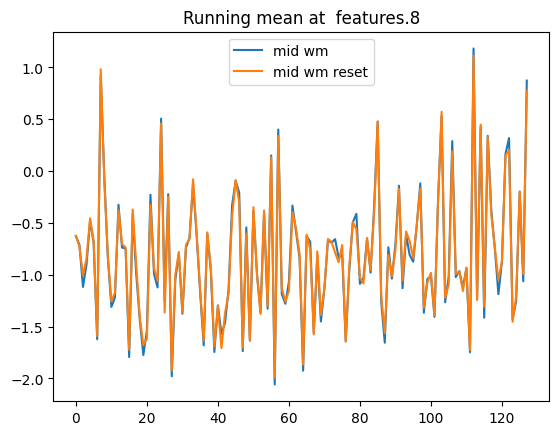

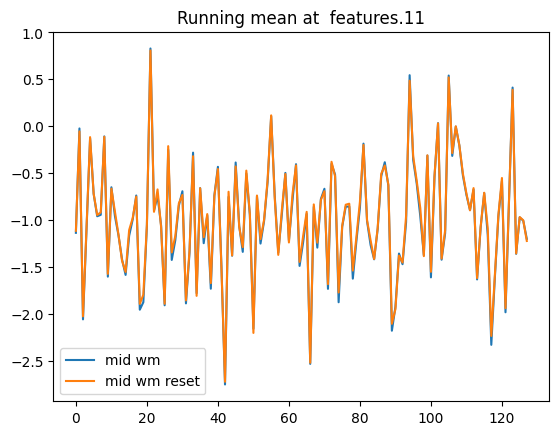

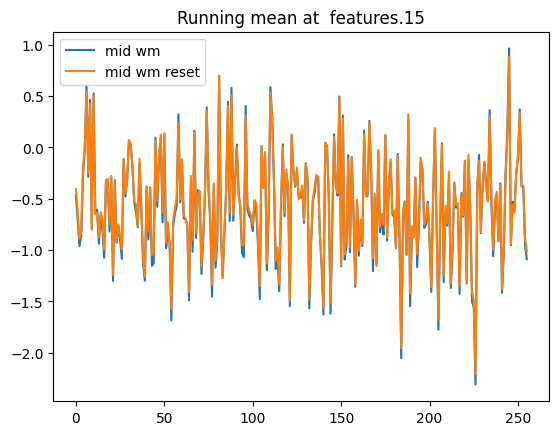

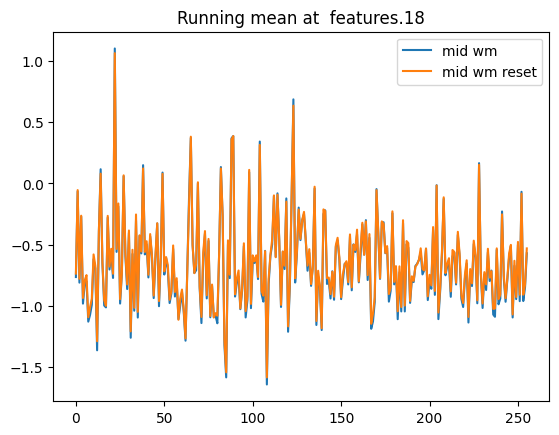

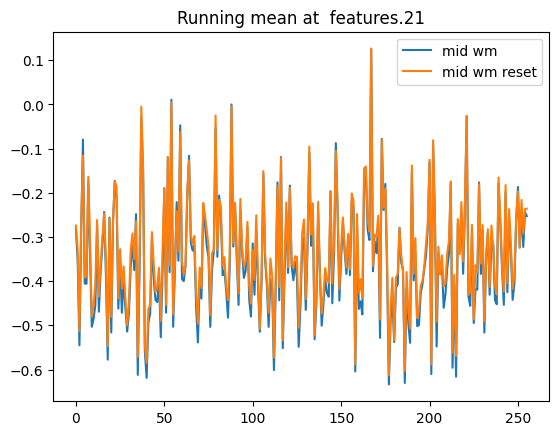

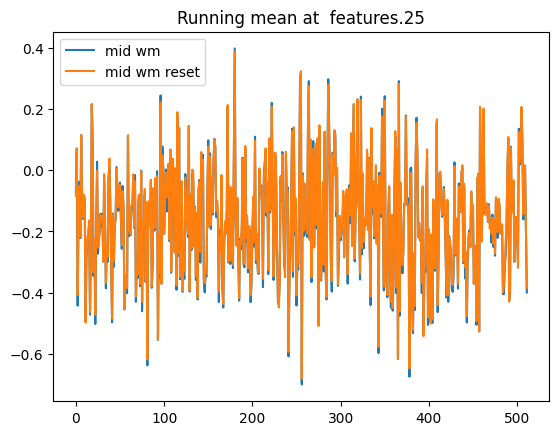

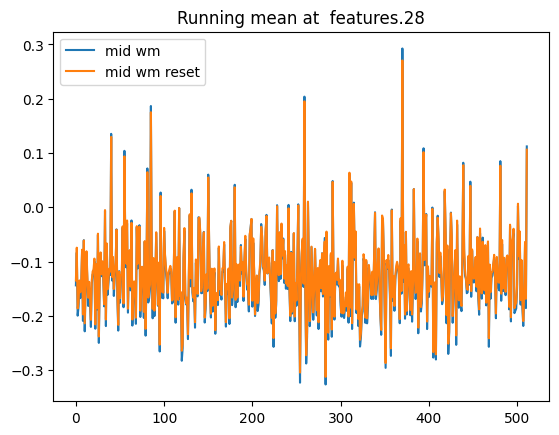

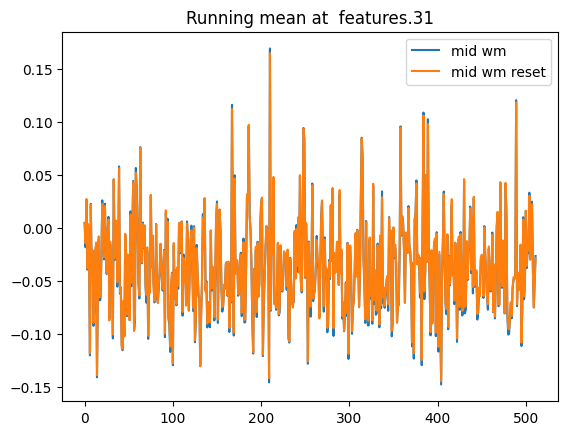

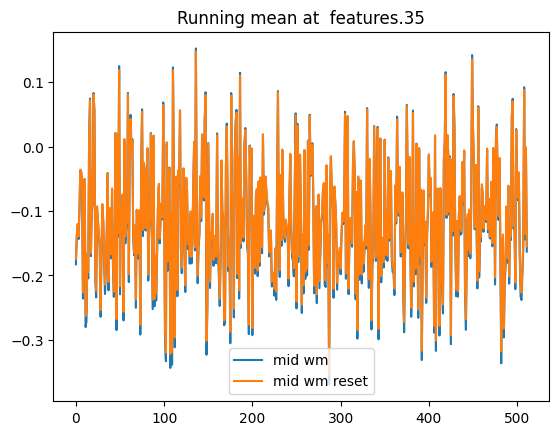

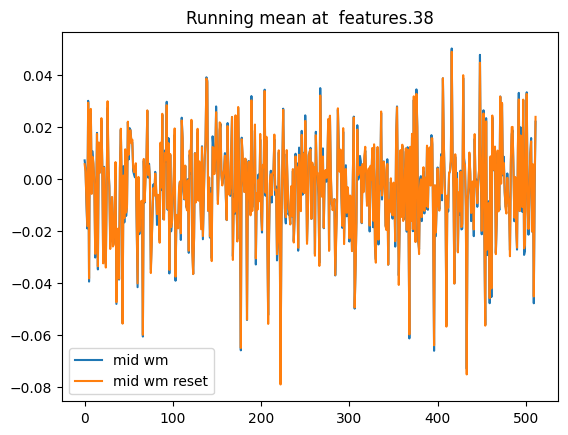

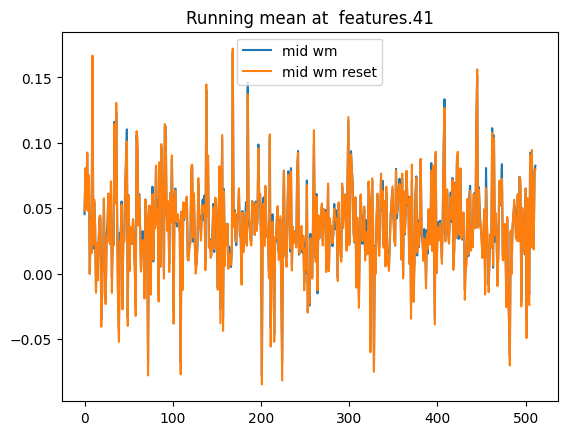

In [7]:
for k in sd_mid_wm:
    if 'running_mean' in k:
        plt.plot(sd_mid_wm[k].cpu().numpy(), label='mid wm')
        plt.plot(sd_mid_wm_reset[k].cpu().numpy(), label='mid wm reset')
        plt.legend()
        plt.title('Running mean at  {}'.format('.'.join(k.split('.')[:2])))
        plt.show()

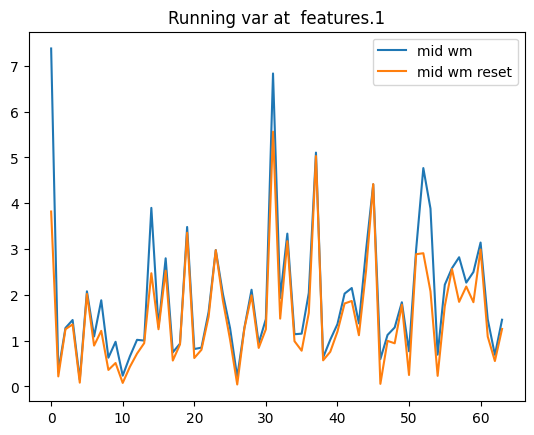

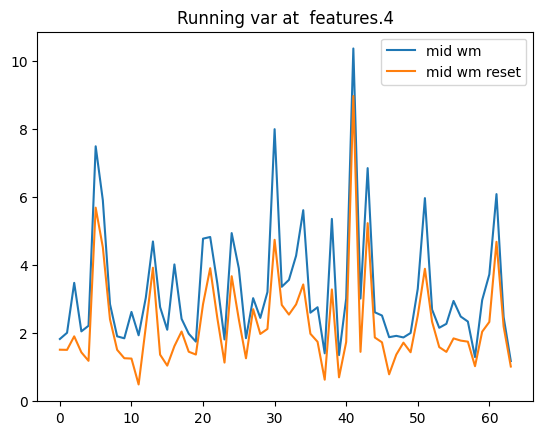

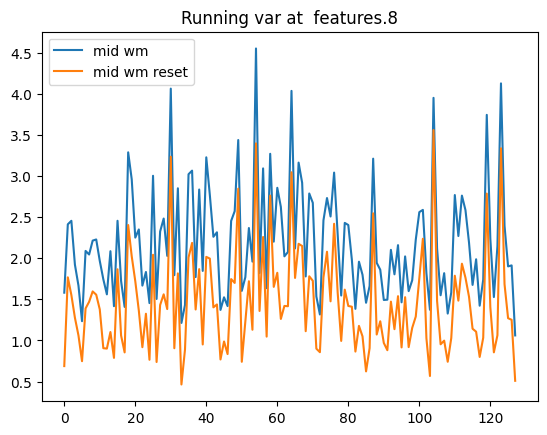

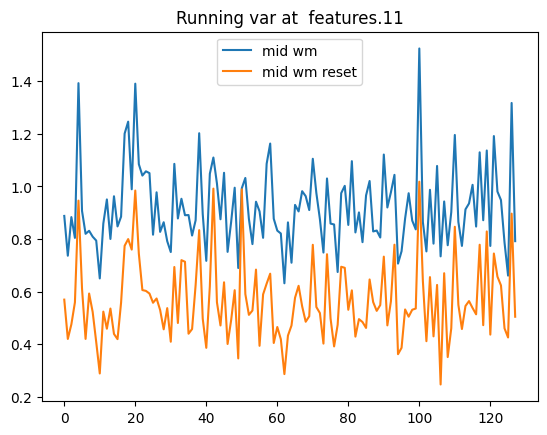

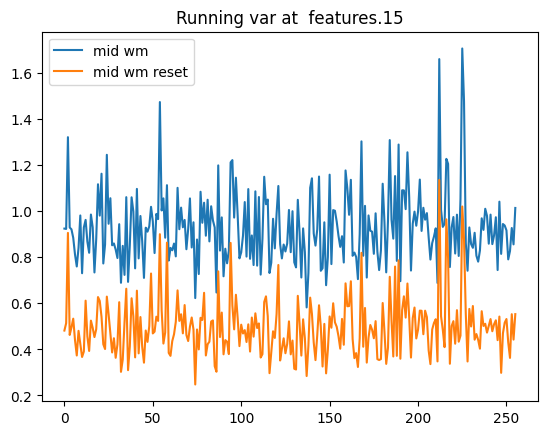

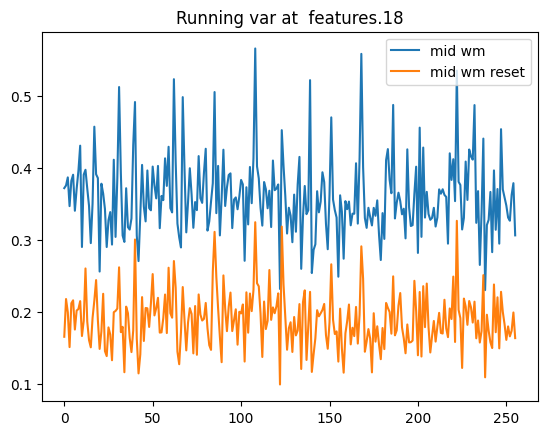

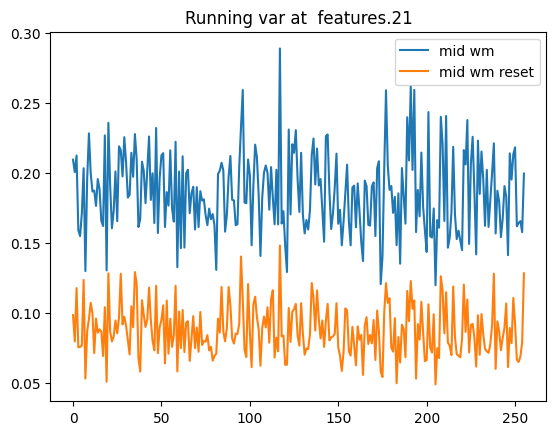

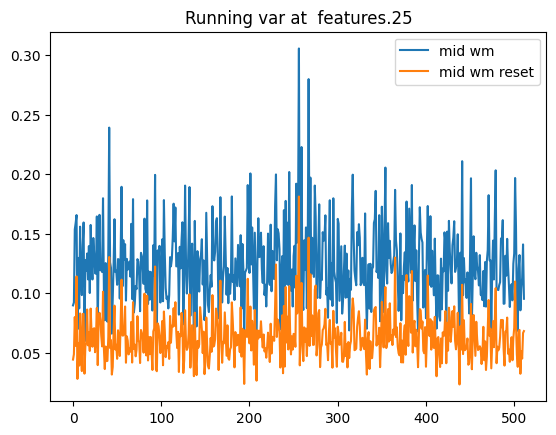

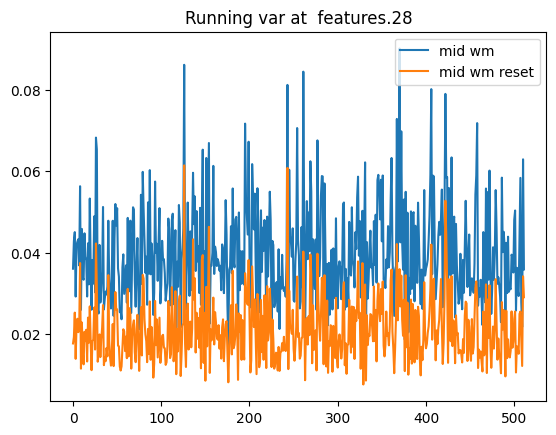

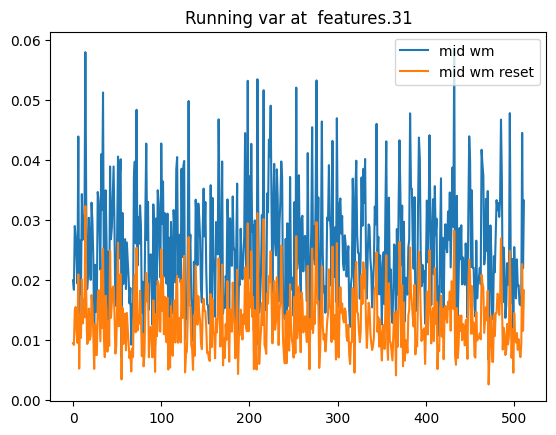

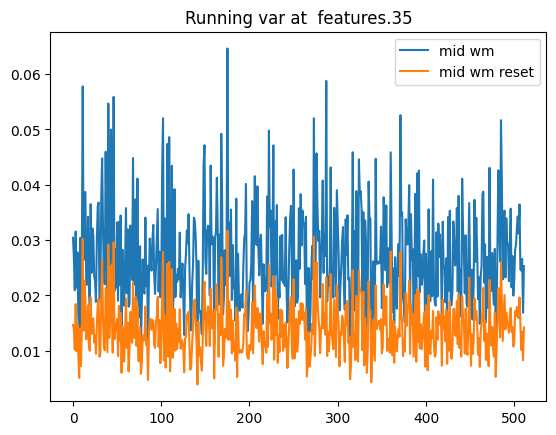

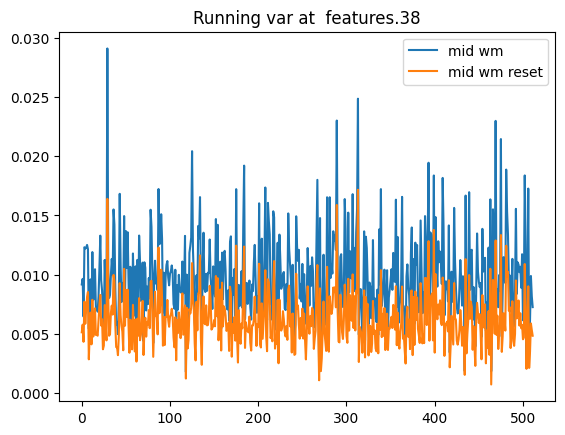

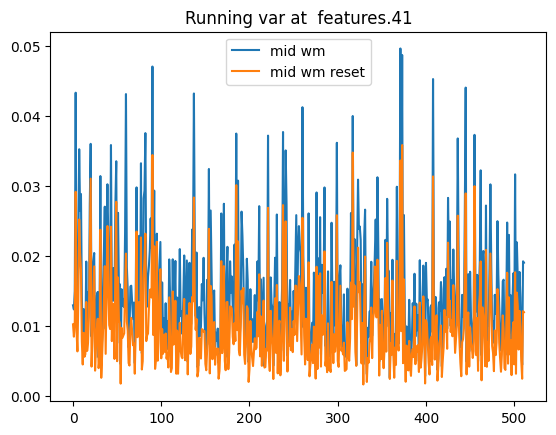

In [8]:
for k in sd_mid_wm:
    if 'running_var' in k:
        plt.plot(sd_mid_wm[k].cpu().numpy(), label='mid wm')
        plt.plot(sd_mid_wm_reset[k].cpu().numpy(), label='mid wm reset')
        plt.legend()
        plt.title('Running var at  {}'.format('.'.join(k.split('.')[:2])))
        plt.show()

#### Visualize for CPAL submission

In [9]:
layer_name = 'features.15'
mean_ori = sd_mid_wm[layer_name + '.running_mean'].cpu().numpy()
var_ori = sd_mid_wm[layer_name + '.running_var'].cpu().numpy()
mean_reset = sd_mid_wm_reset[layer_name + '.running_mean'].cpu().numpy()
var_reset = sd_mid_wm_reset[layer_name + '.running_var'].cpu().numpy()

Text(0.5, 0.98, 'Comparison Before and After Reset (l=15)')

[2024-12-14 11:39:33] (22192) {_mathtext.py:648}INFO - Substituting symbol E from STIXNonUnicode
[2024-12-14 11:39:33] (22192) {_mathtext.py:648}INFO - Substituting symbol E from STIXNonUnicode


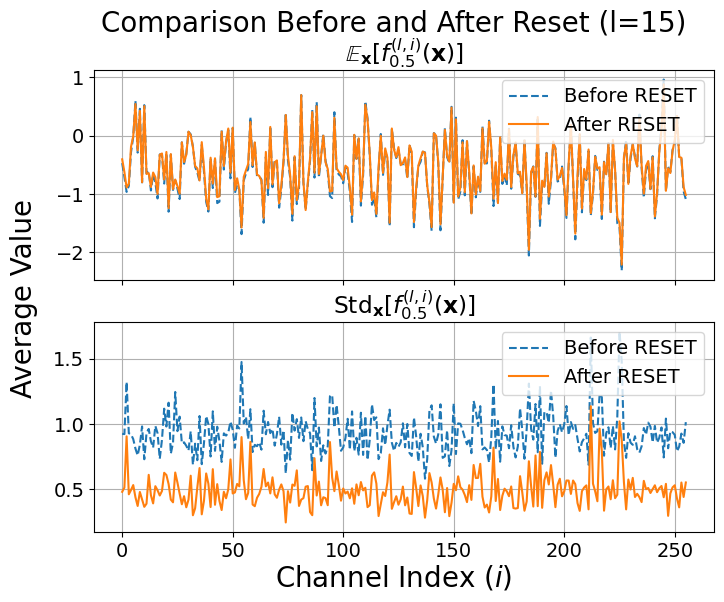

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.rcParams.update({'font.size': 14})

axes[0].plot(mean_ori, label='Before RESET', color='tab:blue', linestyle='--')
axes[0].plot(mean_reset, label='After RESET', color='tab:orange', linestyle='-')
axes[0].set_title(r'$\mathbb{E}_{\mathbf{x}}[f_{0.5}^{(l, i)}(\mathbf{x})]$')
axes[0].legend(loc='upper right')
axes[0].grid(True)
axes[1].plot(var_ori, label='Before RESET', color='tab:blue', linestyle='--')
axes[1].plot(var_reset, label='After RESET', color='tab:orange', linestyle='-')
axes[1].set_title(r'$\mathrm{Std}_{\mathbf{x}}[f_{0.5}^{(l, i)}(\mathbf{x})]$')
axes[1].legend(loc='upper right')
axes[1].grid(True)

fig.supylabel('Average Value', fontsize=20)
fig.supxlabel('Channel Index'+' ($i$)', fontsize=20)
fig.suptitle('Comparison Before and After Reset'+r' (l=15)', fontsize=20)